In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord #, Angle
from gammapy.modeling import Fit, Parameter, Parameters#, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
)


import yaml
import sys
import json

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
from my_dataset_maps_19 import MapDatasetNuisance
from  my_fit_19 import Fit
from gammapy.estimators import FluxPointsEstimator, FluxPoints
from my_estimator_points_sed_19 import My_FluxPointsEstimator
from my_estimator_points_core_19 import My_FluxPoints
#definitons

In [2]:
spatial_model_type = "pointsource_center"
outputfolder = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Fluxpoints/output/data_asimov_tests'
inputfolder_robustness = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Robustness'
path_local_repo_flux = '/home/saturn/caph/mppi045h/Nuisance_Asimov_Fluxpoints'

def get_finished_rnds (amplitude):

    if spatial_model_type == "pointsource_center":
        outputfile ='/Ooutput'+str(amplitude.value)+'.json'

    with open(outputfolder+outputfile, 'r') as f:
        data = json.load(f)
    j = 0
    rnds = list(data.keys()) 
    rnds_st_finished = []
    rnds_N_finished = []
    for i in range(len(rnds)):
        try:
            if (data[str(rnds[i])]['result']['standard'] == 'finished'):
                rnds_st_finished.append(int(rnds[i]))
            if (data[str(rnds[i])]['result']['N'] == 'finished'):
                rnds_N_finished.append(int(rnds[i]))
        except:
            tmep = 1


    print("finished rnds St:", rnds_st_finished)
    print("finished rnds N:", rnds_N_finished)
    return rnds_st_finished, rnds_N_finished


In [3]:
def get_st_fluxpoints (rnd):
    fluxfilename = f"{path_local_repo_flux}/OOutput{amplitude.value}/Flux_{rnd}_{str(amplitude.value)}_st.fits"
    fluxpoints_standard = FluxPoints.read(fluxfilename )
    return fluxpoints_standard

def get_N_fluxpoints (rnd):
    fluxfilename = f"{path_local_repo_flux}/OOutput{amplitude.value}/Flux_{rnd}_{str(amplitude.value)}_N.fits"
    fluxpoints_N = My_FluxPoints.read(fluxfilename )
    return fluxpoints_N

def plot(fluxpoints):
    fig, ax = plt.subplots(1,1)
    for i, fluxpoints_standard in enumerate(fluxpoints):

        if i ==0:

            ax = fluxpoints_standard.plot()
        else:
            fluxpoints_standard.plot(ax = ax)
    return fig

In [4]:
inputfolder_robustness = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Robustness'

models = Models.read(inputfolder_robustness+"/1a-Source_models.yaml")
model_asimov = models[spatial_model_type]

In [19]:
def plot_comparison(ax, fluxes, sed_type, label):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    else:
        fig = plt.gcf()
    if label:
        label = ["Flux-point (Standard)", "Flux-point (with Nui par)"]
        label_mean = ["Mean error (Standard)", "Mean error (with Nui par)"]
        label_std = ["Std. error (Standard)", "Std. error (with Nui par)"]
        label_input = "Input flux"
    else:
        label = ["Mean error (Standard)", "Mean error (with Nui par)"]
        label = ["", ""]; label_mean = ["", ""]; label_std = ["", ""];  label_input = ''
    colors_band = ['yellowgreen','tomato']
    colors = ['green', 'red']
    fmts = ['o', 'x']
    markersizes = [6, 12]

    for i, fluxpoints in enumerate(fluxes):

        fluxes = []
        y_errs = []
        y_errns , y_errps = [], []
        for f in fluxpoints:
            fluxes.append(getattr(f,sed_type).data.flatten())
            y_errs.append(getattr(f, sed_type + "_err").data.flatten())
            y_errn, y_errp = f._plot_get_flux_err(sed_type=sed_type)
            y_errns.append(y_errn.data.flatten()); y_errps.append(y_errp.data.flatten())
        fluxes= np.array(fluxes)
        y_errs= np.array(y_errs)
        y_errns= np.array(y_errns)
        y_errps= np.array(y_errps)
        fluxes_mean = fluxes.mean(axis = 0)
        fluxes_std = fluxes.std(axis = 0)
        y_errs_mean = y_errs.mean(axis = 0 )
        y_errns_mean = y_errns.mean(axis = 0 )
        y_errps_mean = y_errps.mean(axis = 0 )
    
        if np.isnan(y_errns_mean).any() or np.isnan(y_errps_mean).any():
            ern = fluxes_mean -  y_errs_mean
            erp = fluxes_mean+    y_errs_mean 
        else:
            ern = fluxes_mean -  y_errns_mean
            erp = fluxes_mean+  y_errps_mean 
        
        e_center = f.energy_ref.value #*(1+ 0.2 * i)
        bounds1 = (e_center - f.energy_min.value)
        bounds2 = (f.energy_max.value - e_center)
        bounds = np.array(list(zip(bounds1, bounds2))).T
        ax.errorbar(x = e_center, y = fluxes_mean, yerr =fluxes_std, 
                     xerr = bounds,   ecolor=colors_band[i], markersize = markersizes[i], 
                     color = colors[i], fmt = fmts[i],  label = label[i])
        ax.plot( e_center, ern, color = colors[i], label = label_mean[i] )
        
        ax.plot( e_center, erp, color = colors[i], )
        
        ff = f.energy_ref.value.copy()
        #ff[0] -= bounds1[0]; ff[-1] += bounds2[-1]; 
        ax.fill_between(ff, ern  , erp , 
                         color = colors_band[i] ,alpha = 0.12)
        
    ax.set_xscale('log')
    if sed_type == 'dnde' :
        ax.set_yscale('log')
        model_asimov.parameters['amplitude'].value = amplitude.value
        model_asimov.spectral_model.plot(ax = ax, 
                                     energy_bounds = [f.energy_ref.value[0], f.energy_ref.value[-1]] * u.TeV,
                                    color = 'grey',
                                    label = label_input,
                                        sed_type = sed_type)
    if sed_type == 'e2dnde':
        ax.set_yscale('log')
        model_asimov.parameters['amplitude'].value = amplitude.value
        model_asimov.spectral_model.plot(ax = ax, 
                                     energy_bounds = [f.energy_ref.value[0], f.energy_ref.value[-1]] * u.TeV,
                                    color = 'grey',
                                    label = label_input,
                                        sed_type = 'dnde',
                                        energy_power = 2)
    if sed_type=='norm':
        ax.hlines(1, ff[0], ff[-1], color = 'grey', label = label_input)
    ax.legend()
    ax.set_xlabel("Energy [TeV]")
    ax.set_ylabel(f'{sed_type} [{getattr(f,sed_type).unit}]')
    return fig, ax

finished rnds St: [0, 1, 2, 3]
finished rnds N: []


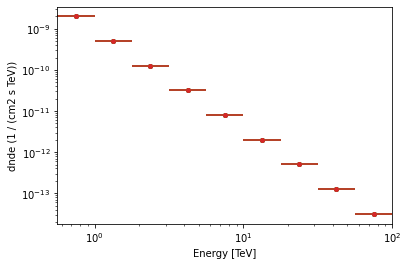

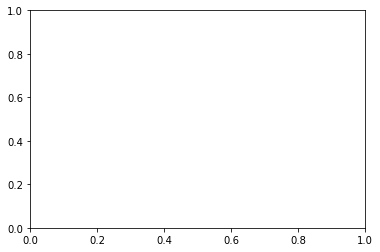

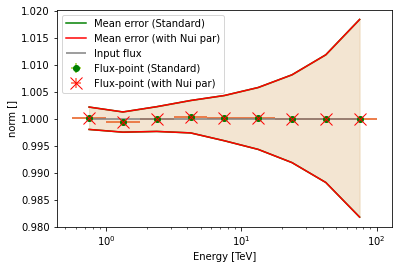

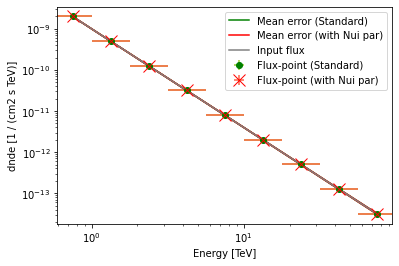

In [20]:
amplitude = 1e-9 * u.Unit('cm-2 s-1 TeV-1')
rnds_19 = get_finished_rnds(amplitude)
fluxpoints_standard_9 = [get_st_fluxpoints(rnd) for rnd in rnds_19[0]]
plot(fluxpoints_standard_9)
fluxpoints_N_9 = [get_st_fluxpoints(rnd) for rnd in rnds_19[1]]
plot(fluxpoints_N_9)
fig ,ax = plot_comparison(None, [fluxpoints_standard_9, fluxpoints_standard_9], 'norm', 1)
fig ,ax = plot_comparison(None, [fluxpoints_standard_9, fluxpoints_standard_9], 'dnde', 1)

finished rnds St: [0, 1, 2]
finished rnds N: [0]


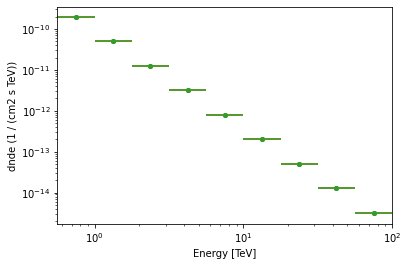

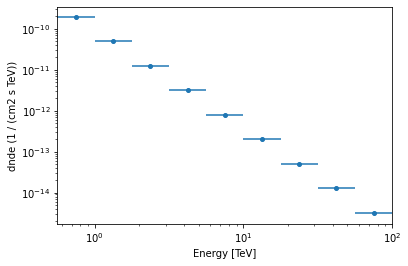

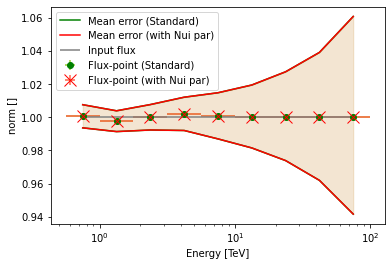

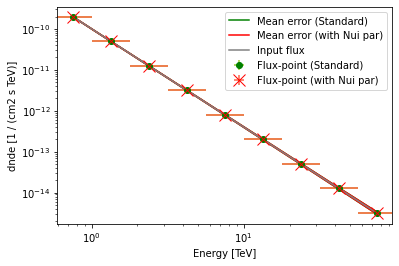

In [22]:
amplitude = 1e-10 * u.Unit('cm-2 s-1 TeV-1')
rnds_110 = get_finished_rnds(amplitude)
fluxpoints_standard_10 = [get_st_fluxpoints(rnd) for rnd in rnds_110[0]]
fig = plot(fluxpoints_standard_10)
fluxpoints_N_10 = [get_st_fluxpoints(rnd) for rnd in rnds_110[1]]
fig = plot(fluxpoints_N_10)
fig  = plot_comparison(None,[fluxpoints_standard_10, fluxpoints_standard_10], 'norm',1)
fig  = plot_comparison(None,[fluxpoints_standard_10, fluxpoints_standard_10], 'dnde',1)

In [ ]:
amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1')
rnds_111 = get_finished_rnds(amplitude)
fluxpoints_standard_11 = [get_st_fluxpoints(rnd) for rnd in rnds_111[0]]
fig = plot(fluxpoints_standard_11)
fluxpoints_N_11 = [get_N_fluxpoints(rnd) for rnd in rnds_111[1]]
fig = plot(fluxpoints_N_11)
fig  = plot_comparison(None,[fluxpoints_standard_11, fluxpoints_N_11],'norm')
fig  = plot_comparison(None,[fluxpoints_standard_11, fluxpoints_N_11],'dnde')

finished rnds St: [0, 1, 2]
finished rnds N: [0]


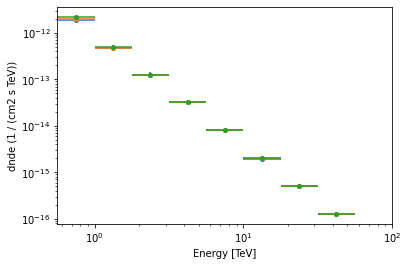

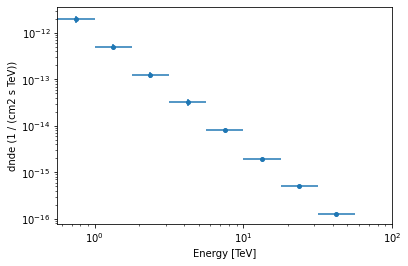

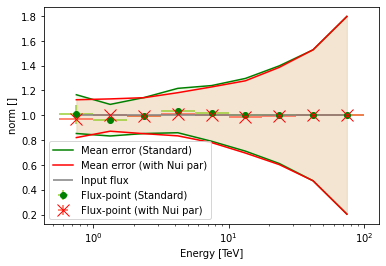

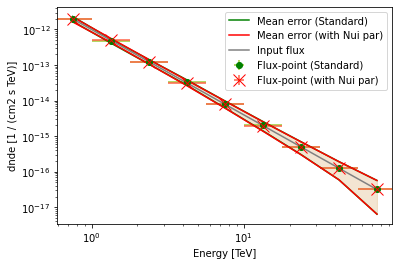

In [23]:
amplitude = 1e-12 * u.Unit('cm-2 s-1 TeV-1')
rnds_112 = get_finished_rnds(amplitude)
fluxpoints_standard_12 = [get_st_fluxpoints(rnd) for rnd in rnds_112[0]]
plot(fluxpoints_standard_12)
fluxpoints_N_12 = [get_N_fluxpoints(rnd) for rnd in rnds_112[1]]
plot(fluxpoints_N_12)
fig  = plot_comparison(None,[fluxpoints_standard_12, fluxpoints_N_12], 'norm',1)
fig  = plot_comparison(None,[fluxpoints_standard_12, fluxpoints_N_12], 'dnde',1)

finished rnds St: [0, 1, 2]
finished rnds N: [0]


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


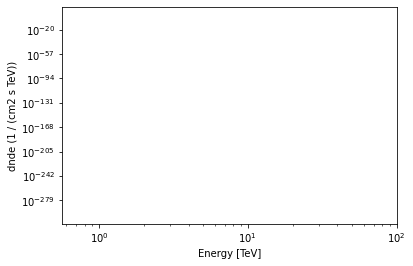

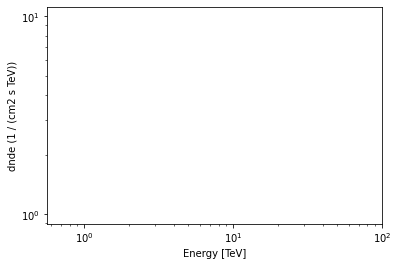

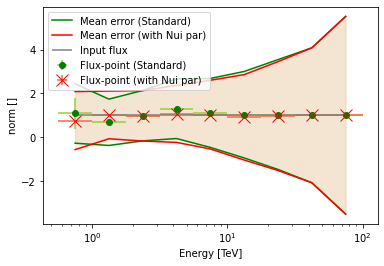

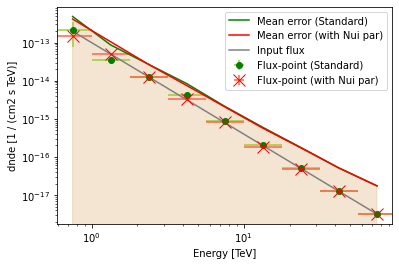

In [24]:
amplitude = 1e-13 * u.Unit('cm-2 s-1 TeV-1')
rnds_113 = get_finished_rnds(amplitude)
fluxpoints_standard_13 = [get_st_fluxpoints(rnd) for rnd in rnds_113[0]]
fig = plot(fluxpoints_standard_13)
fluxpoints_N_13 = [get_N_fluxpoints(rnd) for rnd in rnds_113[1]]
fig = plot(fluxpoints_N_13)
fig  = plot_comparison(None,[fluxpoints_standard_13, fluxpoints_N_13], 'norm',1)
fig  = plot_comparison(None,[fluxpoints_standard_13, fluxpoints_N_13], 'dnde',1)

## Combined Plot

finished rnds St: [0, 1, 2, 3]
finished rnds N: []
finished rnds St: [0, 1, 2]
finished rnds N: [0]


No handles with labels found to put in legend.


finished rnds St: [0, 1, 2]
finished rnds N: [0]


No handles with labels found to put in legend.


finished rnds St: [0, 1, 2]
finished rnds N: [0]


No handles with labels found to put in legend.


finished rnds St: [0, 1, 2]
finished rnds N: [0]


No handles with labels found to put in legend.


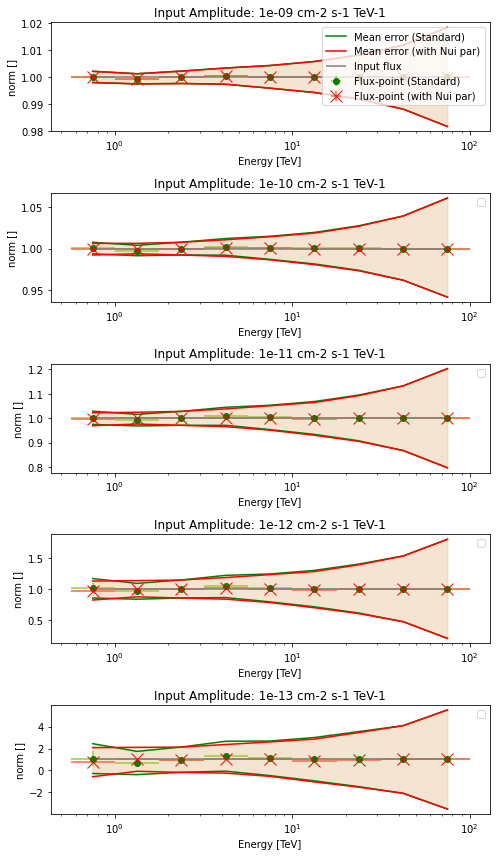

In [38]:
ylim = [-1,3]
amps = [1e-09, 1e-10, 1e-11, 1e-12, 1e-13]
fig,axs = plt.subplots( len(amps), 1, figsize = (7,12))

for i, a in enumerate(amps):
    ax = axs.flatten()[i]
    amplitude = a * u.Unit('cm-2 s-1 TeV-1')
    rnds_121 = get_finished_rnds(amplitude)
    fluxpoints_standard_12 = [get_st_fluxpoints(rnd) for rnd in rnds_121[0]]
    if len(rnds_121[1])>0:
        fluxpoints_N_12 = [get_N_fluxpoints(rnd) for rnd in rnds_121[1]]
    else:
        fluxpoints_N_12 = [get_st_fluxpoints(rnd) for rnd in rnds_121[0]]
    fig, ax = plot_comparison(ax,[fluxpoints_standard_12, fluxpoints_N_12], 'norm',not bool(i))
    ax.set_title(f'Input Amplitude: {a} cm-2 s-1 TeV-1')
    #ax.set_ylim(ylim[0], ylim[1])
plt.tight_layout()

fig.savefig("plots/1_Fluxpoints.png", bbox_inches = "tight")
fig.savefig("plots/1_Fluxpoints.pdf", bbox_inches = "tight")

finished rnds St: [0, 1, 2, 3]
finished rnds N: []
finished rnds St: [0, 1, 2]
finished rnds N: [0]
finished rnds St: [0, 1, 2]
finished rnds N: [0]
finished rnds St: [0, 1, 2]
finished rnds N: [0]
finished rnds St: [0, 1, 2]
finished rnds N: [0]


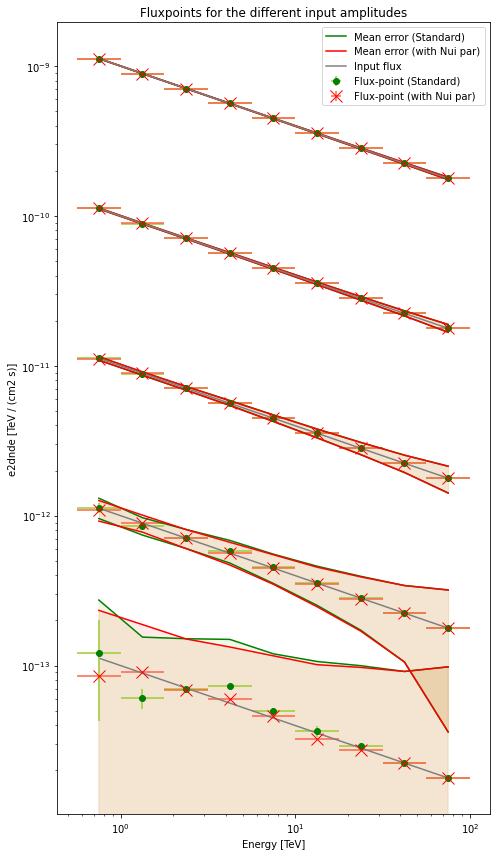

In [37]:
#ylim = [-1,3]
amps = [1e-09, 1e-10, 1e-11, 1e-12, 1e-13]
fig,ax = plt.subplots( 1, 1, figsize = (7,12))
for i, a in enumerate(amps):
    ax =ax
    amplitude = a * u.Unit('cm-2 s-1 TeV-1')
    rnds_121 = get_finished_rnds(amplitude)
    fluxpoints_standard_12 = [get_st_fluxpoints(rnd) for rnd in rnds_121[0]]
    if len(rnds_121[1])>0:
        fluxpoints_N_12 = [get_N_fluxpoints(rnd) for rnd in rnds_121[1]]
    else:
        fluxpoints_N_12 = [get_st_fluxpoints(rnd) for rnd in rnds_121[0]]
    fig, ax = plot_comparison(ax,[fluxpoints_standard_12, fluxpoints_N_12], 'e2dnde', not bool(i))
        
    ax.set_title(f'Fluxpoints for the different input amplitudes')
    #ax.set_ylim(ylim[0], ylim[1])
ylim = ax.get_ylim()
#ax.set_ylim(ylim[0]* 1e-1, ylim[1])
#ax.text(80, a * 0.3, str(a))
ax.set_yscale('log')
plt.tight_layout()

fig.savefig("plots/1_Fluxpoints_dnde.png", bbox_inches = "tight")
fig.savefig("plots/1_Fluxpoints_dnde.pdf", bbox_inches = "tight")

## Computation time

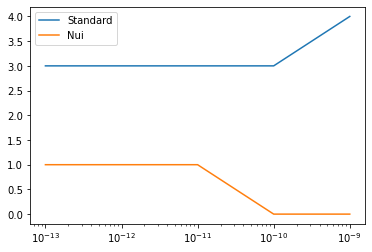

In [13]:
rnds_st = [rnds_19[0], rnds_110[0], rnds_111[0] , rnds_112[0], rnds_113[0]]
rnds_N = [rnds_19[1], rnds_110[1], rnds_111[1] , rnds_112[1], rnds_113[1]]
plt.plot(amps, [len(i) for i in rnds_st],label = "Standard")
plt.plot(amps, [len(i) for i in rnds_N],label = "Nui")
plt.xscale('log')
plt.legend();

| Amplitude | Rnd0 | Rnd1 | Rnd2 |
| --- | --- | --- | --- |
| 1e-09 | 118619 | 118620 | 118621 |
|       |        |        |        |    
| 1e-10 | 118623 | 119266 |119267  |
|       |        |        |        |    
| 1e-11 | 119248 |119264  |119265  |
|       |18:12h  |        |        |   
| 1e-12 | 119249 | 119262 |119263  |
|       |11:11 h |        |        |   
| 1e-13 | 119250 | 119260 |119261  |
|       | 14:58h |        |        |   
| 1e-14 | 119257 | 119258 | 119259 |
|       |        |        |        |   